In [1]:
from act.SyntheticGenerator import SyntheticGenerator
from act.act_types import SimParams, OptimizationParameters
from act.cell_model import TargetCell, ModuleParameters

module_name = "spiker_orig"

target_cell = TargetCell(
    hoc_file="/home/mwsrgf/proj/ACT/data/Spiker/seg/template.hoc",
    mod_folder="/home/mwsrgf/proj/ACT/data/Spiker/seg",
    cell_name="Simple_Spiker_seg",
    g_names = ["gnabar_hh_seg", "gkbar_hh_seg", "gl_hh_seg"]
)

sim_par= SimParams(
            h_v_init=-65.0,  # Consistent with nrngui settings
            h_tstop=500,     # Simulation time in ms
            h_dt=0.1,      # Time step in ms
            h_celsius=6.3,   # Temperature in degrees Celsius
            CI_type="constant",
            CI_amps=[0.1,0.2,0.3],   # Current injection amplitude
            CI_dur=300,      # Duration of current injection
            CI_delay=100,     # Delay before current injection
            set_g_to=[]
        )

sg = SyntheticGenerator(
    ModuleParameters(
        module_folder_name=module_name,
        cell= target_cell,
        sim_params= sim_par,
        optim_params = OptimizationParameters(
            blocked_channels= []
        )
    )
)

sg.generate_synthetic_target_data("target_data.csv")

/home/mwsrgf/act-venv/lib64/python3.9/site-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)
--No graphics will be displayed.


Blocking: []
Total number of jobs: 3
Total number of proccessors: 192
/home/mwsrgf/proj/ACT/model/spiker_orig/synthetic_0.1_0.2_0.3_


# Run Original Pipeline with Passive Prediction

In [2]:
from act.ACTModule import ACTModule
from act.SyntheticGenerator import SyntheticGenerator
from act.act_types import  Cell, SimParams, OptimizationParameters, OptimizationParam
from act.cell_model import ModuleParameters
from act.PassivePropertiesModule import PassivePropertiesModule
from act.act_types import SimParams
from act.cell_model import TrainCell

train_cell = TrainCell(
    hoc_file="/home/mwsrgf/proj/ACT/data/Spiker/seg/template.hoc",
    mod_folder="/home/mwsrgf/proj/ACT/data/Spiker/seg",
    cell_name="Simple_Spiker_seg",
    g_names = ["gnabar_hh_seg", "gkbar_hh_seg", "gl_hh_seg"]
)

mod = ACTModule(
    ModuleParameters(
        module_folder_name=module_name,
        cell= train_cell,
        target_traces_file = "target_data.csv",
        sim_params= sim_par,
        optim_params= OptimizationParameters(
            g_ranges_slices= [
                OptimizationParam(param="gnabar_hh_seg", low=0.0, high=0.3, n_slices=15),
                OptimizationParam(param="gkbar_hh_seg", low=0.0, high=0.3, n_slices=15),
                OptimizationParam(param="gl_hh_seg", low=0.0, high=0.3, n_slices=15),
                
            ],
            prediction_eval_method='fi_curve'
        )
    )
)

In [3]:
predicted_g_data_file = mod.run()

RUNNING THE MODULE
LOADING TARGET TRACES
SIMULATING TRAINING DATA
Total number of jobs: 10125
Total number of proccessors: 192
MECHANISMS already loaded.
/home/mwsrgf/proj/ACT/model/spiker_orig/train
TRAINING RANDOM FOREST REGRESSOR
-------------------------------------------------
GENERATING ARIMA STATS
-------------------------------------------------
ARIMA order set to (4, 0, 4)


100%|██████████| 3/3 [00:04<00:00,  1.36s/it]


-------------------------------------------------
GENERATING ARIMA STATS
-------------------------------------------------
ARIMA order set to (4, 0, 4)


100%|██████████| 10125/10125 [1:30:31<00:00,  1.86it/s] 


Extracting features: ['I_mean', 'I_stdev', 'Num Spikes', 'Interspike Interval', 'Avg Min Spike Height', 'Avg Max Spike Height', 'V_mean', 'amplitude', 'frequency', 'arima0', 'arima1', 'arima2', 'arima3', 'arima4', 'arima5', 'arima6', 'arima7', 'arima8', 'arima9']
Evaluating random forest
MAE: 0.029963 (0.000855)
Predicted Conductances for each current injection intensity: 
[[0.11618571 0.05290714 0.        ]
 [0.10294286 0.02753571 0.        ]
 [0.10103571 0.02616429 0.        ]]
SIMULATING PREDICTIONS
Total number of jobs: 9
Total number of proccessors: 192
MECHANISMS already loaded.
/home/mwsrgf/proj/ACT/model/spiker_orig/prediction_eval0
/home/mwsrgf/proj/ACT/model/spiker_orig/prediction_eval1
/home/mwsrgf/proj/ACT/model/spiker_orig/prediction_eval2
SELECTING BEST PREDICTION
FI curve MAE for each prediction: 
[8.888888888888886, 18.888888888888886, 18.888888888888886]
{'gnabar_hh_seg': 0.11618571428571546, 'gkbar_hh_seg': 0.05290714285714357, 'gl_hh_seg': 0.0}


In [4]:
mod.pickle_rf(mod.rf_model,f"./model/{module_name}/trained_rf.pkl")

In [5]:
from act import ACTPlot
ACTPlot.plot_v_comparison(predicted_g_data_file, f"./model/{module_name}/target", f"./model/{module_name}", [0.1,0.2,0.3])
ACTPlot.plot_fi_comparison(f"./model/{module_name}/results/frequency_data.npy", [0.1,0.2,0.3])

Ordered [   2  238 9014] to [9014    2  238]
Ordered [    3   114 10014] to [10014     3   114]
Ordered [    4    15 10114] to [10114     4    15]
Ordered [    5     6 10124] to [10124     5     6]


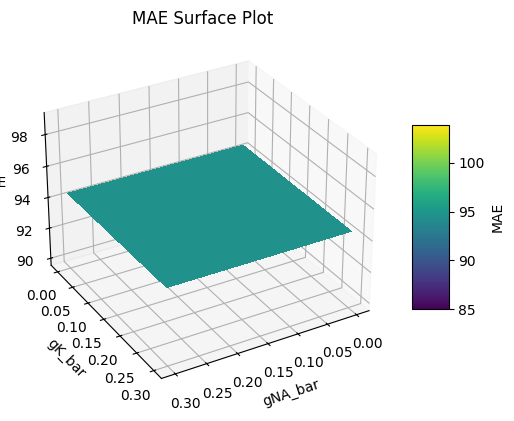

In [6]:
from act import ACTPlot as actplt

actplt.plot_training_fi_mae_surface_spiker_cell(
f"./model/{module_name}/target/combined_out.npy",
f"./model/{module_name}/train/combined_out.npy",
[0.1,0.2,0.3],
300,
100,
0.1,
f"./model/{module_name}/results/FI_MAE_Surface.html",
)